In [19]:
# install dependencies
!pip install transformers
!pip install einops
!pip install accelerate
!pip install torchattacks
!pip install adversarial-robustness-toolbox

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 17.7 MB/s eta 0:00:00


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

# Import dependencies

In [23]:
# import libraries
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision import datasets, models
import numpy as np
import matplotlib.pyplot as plt
import torchattacks
from torchvision import models
from torchvision.models import ResNet18_Weights



# Load data set

In [5]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Load the training and test sets

In [6]:
train_set = datasets.ImageFolder(root='/content/drive/MyDrive/Colab Notebooks/medical_data/train', transform=transform)
train_loader = DataLoader(train_set, batch_size=16, shuffle=True)

test_set = datasets.ImageFolder(root='/content/drive/MyDrive/Colab Notebooks/medical_data/test', transform=transform)
test_loader = DataLoader(test_set, batch_size=16, shuffle=False)


# # Define the Model : pre-trained ResNet-18 model

In [ ]:
model = models.resnet18(weights=ResNet18_Weights.IMAGENET1K_V1)
model.fc = torch.nn.Linear(512, len(train_set.classes))
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)
model.fc = nn.Linear(512, len(train_set.classes))
model = model.cuda()
model.zero_grad()

# Train the Model

In [14]:
# Train the Model

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

for epoch in range(30):  # Increase epochs as needed
    for images, labels in train_loader:
        #images, labels = images.cuda(), labels.cuda()
        images, labels = images.to(device), labels.to(device)
        #images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

print('Finished Training')

Finished Training


# Before Attack Pridiction

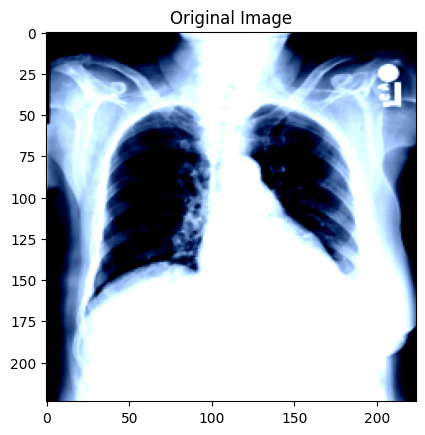

Prediction before attack: 0


In [15]:
# Before Attack
dataiter = iter(test_loader)
images, labels = next(dataiter)
image = images[0].to(device)
label = labels[0].to(device)

# Display original image
original_image = image.cpu().numpy().transpose(1, 2, 0)
plt.imshow(original_image)
plt.title("Original Image")
plt.show()

# Predict on original image
model.eval()
with torch.no_grad():
    output = model(image.unsqueeze(0))
    _, predicted = torch.max(output.data, 1)
    print("Prediction before attack:", predicted.item())


# Model Evaluation

In [16]:
def evaluate_model(model, loader):
    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    print(f'Accuracy of the model on the test images: {100 * correct / total} %')

evaluate_model(model, test_loader)

Accuracy of the model on the test images: 52.32876712328767 %


# adversarial image

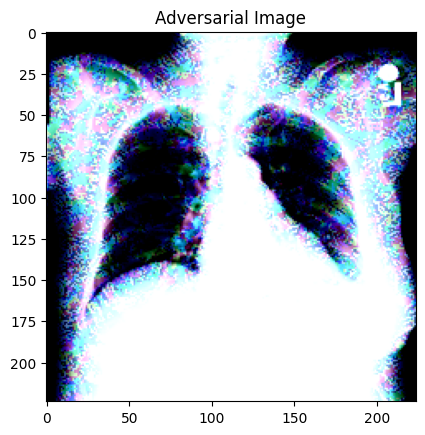

Prediction on adversarial image (before training): 0


In [26]:
import art
from art.attacks.evasion import FastGradientMethod
from art.estimators.classification import PyTorchClassifier

classifier = PyTorchClassifier(
    model=model,
    clip_values=(0, 1),  # Adjust clip values based on your data range
    loss=torch.nn.CrossEntropyLoss(),
    input_shape=(3, 224, 224),  # Adjust input shape if necessary
    nb_classes=2, # Adjust number of classes if necessary
)

# Create an FGSM
adversary = FastGradientMethod(estimator=classifier, eps=0.2)

# Convert the image tensor to a NumPy array before passing to 'generate'
image_np = image.unsqueeze(0).cpu().numpy()
label_np = label.unsqueeze(0).cpu().numpy()

# Generate adversarial image
adv_image = adversary.generate(x=image_np, y=label_np)[0]

# Display adversarial image
adv_image_np = adv_image.transpose(1, 2, 0)
plt.imshow(adv_image_np)
plt.title("Adversarial Image")
plt.show()

# Convert the adversarial image back to a PyTorch tensor for prediction
adv_image_tensor = torch.tensor(adv_image).to(device)

# Predict on adversarial image
with torch.no_grad():
    output = model(adv_image_tensor.unsqueeze(0))
    _, predicted = torch.max(output.data, 1)
    print("Prediction on adversarial image (before training):", predicted.item())

# Apply the FGSM attack

In [28]:
# Apply the FGSM attack

adversary = torchattacks.FGSM(model, eps=0.03)

def adversarial_attack(model, loader):
    model.eval()
    correct = 0
    total = 0
    # Use the device agnostic way to move tensors
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    for images, labels in loader:
        images, labels = images.to(device), labels.to(device)
        adv_images = adversary(images, labels)
        outputs = model(adv_images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    print(f'Accuracy on adversarial examples: {100 * correct / total} %')

adversarial_attack(model, test_loader)

Accuracy on adversarial examples: 44.657534246575345 %


# Evaluate the model on the original test set before adversarial training

In [29]:
# Evaluate the model on the original test set after adversarial training
evaluate_model(model, test_loader)

Accuracy of the model on the test images: 52.32876712328767 %


# Model Accuracy Before training

In [30]:

model.eval()
with torch.no_grad():
    output = model(image.unsqueeze(0))
    probabilities = torch.nn.functional.softmax(output.data, dim=1)
    confidence, predicted = torch.max(probabilities, 1)
    print("Prediction before attack:", predicted.item(), "Confidence:", confidence.item())



Prediction before attack: 0 Confidence: 0.9764251112937927


# Adversarial Training

In [32]:
def adversarial_training(model, loader, optimizer, criterion, epochs=5):
    model.train()
    for epoch in range(epochs):
        for images, labels in loader:
            adv_images = adversary(images, labels)

            optimizer.zero_grad()
            outputs = model(adv_images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

adversarial_training(model, train_loader, optimizer, criterion)

# After Adversarial Training

In [34]:
with torch.no_grad():
    output = model(image.unsqueeze(0))
    _, predicted = torch.max(output.data, 1)
    print("Prediction after adversarial training:", predicted.item())

adv_image_after = adversary(image.unsqueeze(0), label.unsqueeze(0))[0]

with torch.no_grad():
    output = model(adv_image_after.unsqueeze(0))
    _, predicted = torch.max(output.data, 1)
    print("Prediction on adversarial image (after training):", predicted.item())

Prediction after adversarial training: 0
Prediction on adversarial image (after training): 0


# Evaluate the model on the original test set after adversarial training

In [35]:
evaluate_model(model, test_loader)

Accuracy of the model on the test images: 56.16438356164384 %


# Accuracy after Adversarial training

In [36]:
with torch.no_grad():
    output = model(image.unsqueeze(0))
    probabilities = torch.nn.functional.softmax(output.data, dim=1)
    confidence, predicted = torch.max(probabilities, 1)
    print("Prediction after adversarial training:", predicted.item(), "Confidence:", confidence.item())

with torch.no_grad():
    output = model(adv_image_after.unsqueeze(0))
    probabilities = torch.nn.functional.softmax(output.data, dim=1)
    confidence, predicted = torch.max(probabilities, 1)
    print("Prediction on adversarial image (after training):", predicted.item(), "Confidence:", confidence.item())



Prediction after adversarial training: 1 Confidence: 0.6780851483345032
Prediction on adversarial image (after training): 1 Confidence: 0.9644847512245178


#Evaluate the Defense

In [37]:
#Evaluate the Defense

adversarial_attack(model, test_loader)


Accuracy on adversarial examples: 60.0 %
